In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np

from tqdm.notebook import trange
from sklearn import metrics

# 导入数据

In [2]:
data_train = pd.read_csv("./data/train_dataset_embedding.csv")
train_embeddings = data_train["text_embedding"].apply(lambda x: json.loads(x))
data_test = pd.read_csv("./data/test_dataset_embedding.csv")
test_embeddings = data_test["text_embedding"].apply(lambda x: json.loads(x))

In [3]:
data_train = pd.read_csv("./data/train_dataset.csv")
data_test = pd.read_csv("./data/test_dataset.csv")

# 向量检索

In [4]:
def cosine_similarity_matrix(A, B):
    # 计算矩阵A中每个向量与矩阵B中每个向量的余弦相似性
    dot_products = np.dot(A, B.T)
    norms_A = np.linalg.norm(A, axis=1)
    norms_B = np.linalg.norm(B, axis=1)
    similarities = dot_products / np.outer(norms_A, norms_B)
    return similarities


A = np.array(test_embeddings.to_list())
B = np.array(train_embeddings.to_list())
similarities = cosine_similarity_matrix(A, B)
topk_similarities = np.argsort(-similarities)
print(topk_similarities.shape)

(3130, 12521)


# 模型导入

In [5]:
from modelscope import AutoModelForCausalLM, AutoTokenizer

device = "cuda"  # the device to load the model onto

model = AutoModelForCausalLM.from_pretrained(
    "qwen/Qwen1.5-7B-Chat-GPTQ-Int4", device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("qwen/Qwen1.5-7B-Chat-GPTQ-Int4")

2024-04-01 15:39:05,608 - modelscope - INFO - PyTorch version 2.1.2+cu121 Found.
2024-04-01 15:39:05,610 - modelscope - INFO - Loading ast index from /root/.cache/modelscope/ast_indexer
2024-04-01 15:39:05,648 - modelscope - INFO - Loading done! Current index file version is 1.9.5, with md5 11682d82f4c9d9d717e5e852542fe124 and a total number of 945 components indexed
CUDA extension not installed.
CUDA extension not installed.
/root/miniconda3/lib/python3.10/site-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# few-shot+KNN生成回答

## 3-shot

In [6]:
def generate_response(system_content, content):
    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": content},
    ]
    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=256)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return response

In [7]:
content_list = data_test["joke"].to_list()
retrieval_list = data_train["joke"].to_list()

In [8]:
def generate_label(num, k, system_content, max_retries=3):
    responses = []
    for i in trange(num):
        retries = 0
        while retries < max_retries:
            content = ""
            for j in topk_similarities[1][:k]:
                content += (
                    "#文本："
                    + retrieval_list[j]
                    + "\n幽默程度："
                    + data_train["joke"].iloc[j]
                )
            content += "#文本：" + content_list[i] + "\n幽默程度："
            response = generate_response(system_content, content)
            if response in ["弱幽默", "一般幽默", "强幽默"]:
                responses.append(response)
                break
            else:
                retries += 1
                print(f"回答{i}生成错误！生成的结果为：{response}")
        else:
            print(f"回答{i}生成错误次数超过上限！")

    return responses

In [9]:
k = 3
system_content = f"你是一位语言学家，你将得到由#号分隔开的{k+1}段文本，其中前{k}段文本包含了文字与该段文字幽默程度的标签。你需要判断最后一段文本的幽默程度的标签，输出只能是'弱幽默','一般幽默','强幽默'三者之一"

In [10]:
responses = generate_label(len(content_list), k, system_content)  # len(content_list)

  0%|          | 0/3130 [00:00<?, ?it/s]

In [11]:
prediction = data_test[["label"]].copy()
prediction["3-shot-knn"] = responses

In [12]:
prediction["3-shot-knn"] = prediction["3-shot-knn"].replace(
    {"弱幽默": 0, "一般幽默": 1, "强幽默": 2}
)
prediction["3-shot-knn"].value_counts()

/tmp/ipykernel_3244/382738582.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prediction["3-shot-knn"] = prediction["3-shot-knn"].replace(


3-shot-knn
2    1853
0    1277
Name: count, dtype: int64

## 2-shot

In [87]:
k = 2
system_content = f"你是一位语言学家，你将得到由#号分隔开的{k+1}段文本，其中前{k}段文本包含了文字与该段文字幽默程度的标签。你需要判断最后一段文本的幽默程度的标签，输出只能是'弱幽默','一般幽默','强幽默'三者之一"

responses = generate_label(len(content_list), k, system_content)  # len(content_list)

  0%|          | 0/3130 [00:00<?, ?it/s]

In [90]:
prediction["2-shot-knn"] = responses

In [91]:
prediction["2-shot-knn"] = prediction["2-shot-knn"].replace(
    {"弱幽默": 0, "一般幽默": 1, "强幽默": 2}
)
prediction["2-shot-knn"].value_counts()

/tmp/ipykernel_3111/3615279348.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prediction["2-shot-knn"] = prediction["2-shot-knn"].replace(


2-shot-knn
0    2043
2    1085
1       2
Name: count, dtype: int64

In [93]:
prediction.to_csv("./data/prediction.csv", index=False)

## 1-shot

In [15]:
k = 1
system_content = f"你是一位语言学家，你将得到由#号分隔开的{k+1}段文本，其中前{k}段文本包含了文字与该段文字幽默程度的标签。你需要判断最后一段文本的幽默程度的标签，输出只能是'弱幽默','一般幽默','强幽默'三者之一"

responses = generate_label(len(content_list), k, system_content)  # len(content_list)

  0%|          | 0/3130 [00:00<?, ?it/s]

In [16]:
prediction["1-shot-knn"] = responses
prediction["1-shot-knn"] = prediction["1-shot-knn"].replace(
    {"弱幽默": 0, "一般幽默": 1, "强幽默": 2}
)
prediction["1-shot-knn"].value_counts()

/tmp/ipykernel_3244/2774416117.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prediction["1-shot-knn"] = prediction["1-shot-knn"].replace(


1-shot-knn
0    1750
2    1274
1     106
Name: count, dtype: int64

# 对比实验：KNN VS 随机挑选数据

In [24]:
import numpy as np


def generate_label_random(num, k, system_content, max_retries=3):
    responses = []
    for i in trange(num):
        retries = 0
        while retries < max_retries:
            content = ""
            for j in np.random.randint(0, len(retrieval_list), k):
                content += (
                    "#文本："
                    + retrieval_list[j]
                    + "\n幽默程度："
                    + data_train["joke"].iloc[j]
                )
            content += "#文本：" + content_list[i] + "\n幽默程度："
            response = generate_response(system_content, content)
            if response in ["弱幽默", "一般幽默", "强幽默"]:
                responses.append(response)
                break
            else:
                retries += 1
        else:
            print(f"回答{i}生成错误次数超过上限！生成的结果为：{response}")

    return responses

## 3-shot

In [25]:
k = 3
system_content = f"你是一位语言学家，你将得到由#号分隔开的{k+1}段文本，其中前{k}段文本包含了文字与该段文字幽默程度的标签。你需要判断最后一段文本的幽默程度的标签，输出只能是'弱幽默','一般幽默','强幽默'三者之一"

responses = generate_label_random(
    len(content_list), k, system_content
)  # len(content_list)

prediction["3-shot-random"] = responses
prediction["3-shot-random"] = prediction["3-shot-random"].replace(
    {"弱幽默": 0, "一般幽默": 1, "强幽默": 2}
)
prediction["3-shot-random"].value_counts()

  0%|          | 0/3130 [00:00<?, ?it/s]

/tmp/ipykernel_3244/2963665161.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prediction["3-shot-random"] = prediction["3-shot-random"].replace(


3-shot-random
2    1798
0    1309
1      23
Name: count, dtype: int64

## 2-shot

In [27]:
k = 2
system_content = f"你是一位语言学家，你将得到由#号分隔开的{k+1}段文本，其中前{k}段文本包含了文字与该段文字幽默程度的标签。你需要判断最后一段文本的幽默程度的标签，输出只能是'弱幽默','一般幽默','强幽默'三者之一"

responses = generate_label_random(
    len(content_list), k, system_content
)  # len(content_list)

prediction["2-shot-random"] = responses
prediction["2-shot-random"] = prediction["2-shot-random"].replace(
    {"弱幽默": 0, "一般幽默": 1, "强幽默": 2}
)
prediction["2-shot-random"].value_counts()

  0%|          | 0/3130 [00:00<?, ?it/s]

/tmp/ipykernel_3244/4269944954.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prediction["2-shot-random"] = prediction["2-shot-random"].replace(


2-shot-random
2    1722
0    1364
1      44
Name: count, dtype: int64

## 1-shot

In [28]:
k = 1
system_content = f"你是一位语言学家，你将得到由#号分隔开的{k+1}段文本，其中前{k}段文本包含了文字与该段文字幽默程度的标签。你需要判断最后一段文本的幽默程度的标签，输出只能是'弱幽默','一般幽默','强幽默'三者之一"

responses = generate_label_random(
    len(content_list), k, system_content
)  # len(content_list)

prediction["1-shot-random"] = responses
prediction["1-shot-random"] = prediction["1-shot-random"].replace(
    {"弱幽默": 0, "一般幽默": 1, "强幽默": 2}
)
prediction["1-shot-random"].value_counts()

  0%|          | 0/3130 [00:00<?, ?it/s]

/tmp/ipykernel_3244/1695861767.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prediction["1-shot-random"] = prediction["1-shot-random"].replace(


1-shot-random
0    1664
2    1350
1     116
Name: count, dtype: int64

# 模型评估

In [17]:
def evaluate(targets, outputs):
    conf = metrics.confusion_matrix(targets, outputs)
    data = pd.DataFrame(
        conf,
        columns=["weak humor", "general humor", "strong humor"],
        index=["weak humor", "general humor", "strong humor"],
    )
    plt.figure(figsize=(6, 5))
    sns.heatmap(data, cmap=plt.cm.Blues, annot=True, fmt="d")
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix", fontsize=16)
    plt.show()
    print("Classification Report")
    print(metrics.classification_report(targets, outputs, zero_division=1))

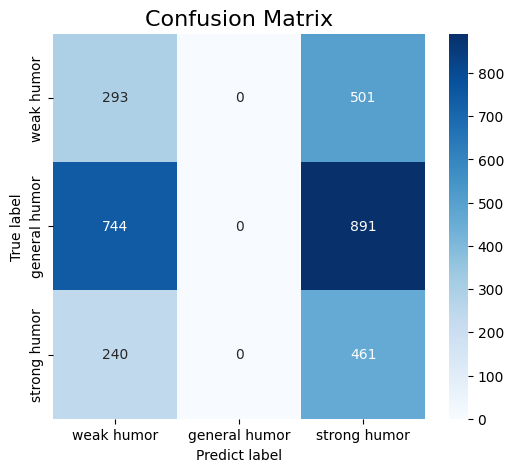

Classification Report
              precision    recall  f1-score   support

           0       0.23      0.37      0.28       794
           1       1.00      0.00      0.00      1635
           2       0.25      0.66      0.36       701

    accuracy                           0.24      3130
   macro avg       0.49      0.34      0.21      3130
weighted avg       0.64      0.24      0.15      3130



In [18]:
evaluate(prediction["label"], prediction["3-shot-knn"])

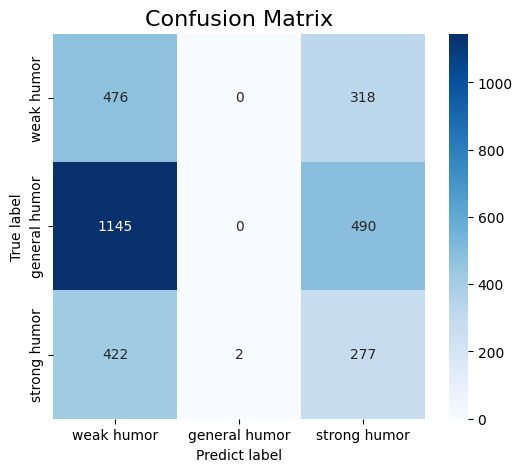

Classification Report
              precision    recall  f1-score   support

           0       0.23      0.60      0.34       794
           1       0.00      0.00      0.00      1635
           2       0.26      0.40      0.31       701

    accuracy                           0.24      3130
   macro avg       0.16      0.33      0.22      3130
weighted avg       0.12      0.24      0.15      3130



In [23]:
evaluate(prediction["label"], prediction["2-shot-knn"])

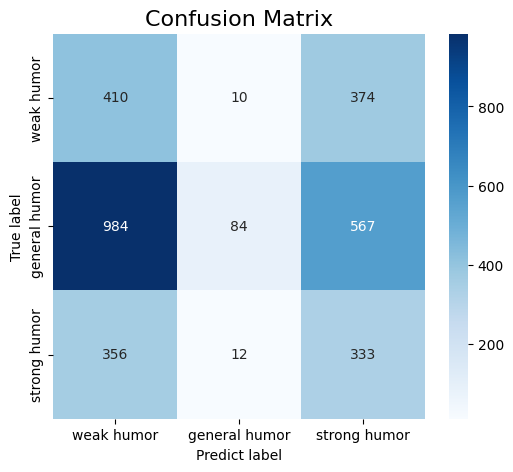

Classification Report
              precision    recall  f1-score   support

           0       0.23      0.52      0.32       794
           1       0.79      0.05      0.10      1635
           2       0.26      0.48      0.34       701

    accuracy                           0.26      3130
   macro avg       0.43      0.35      0.25      3130
weighted avg       0.53      0.26      0.21      3130



In [19]:
evaluate(prediction["label"], prediction["1-shot-knn"])

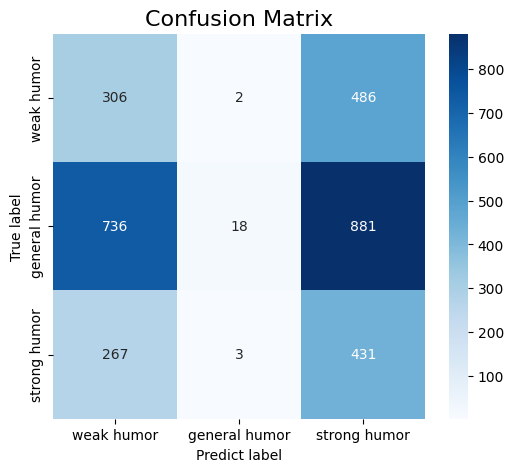

Classification Report
              precision    recall  f1-score   support

           0       0.23      0.39      0.29       794
           1       0.78      0.01      0.02      1635
           2       0.24      0.61      0.34       701

    accuracy                           0.24      3130
   macro avg       0.42      0.34      0.22      3130
weighted avg       0.52      0.24      0.16      3130



In [29]:
evaluate(prediction["label"], prediction["3-shot-random"])

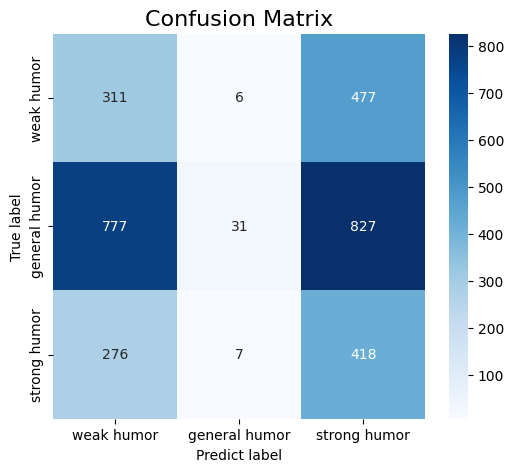

Classification Report
              precision    recall  f1-score   support

           0       0.23      0.39      0.29       794
           1       0.70      0.02      0.04      1635
           2       0.24      0.60      0.35       701

    accuracy                           0.24      3130
   macro avg       0.39      0.34      0.22      3130
weighted avg       0.48      0.24      0.17      3130



In [30]:
evaluate(prediction["label"], prediction["2-shot-random"])

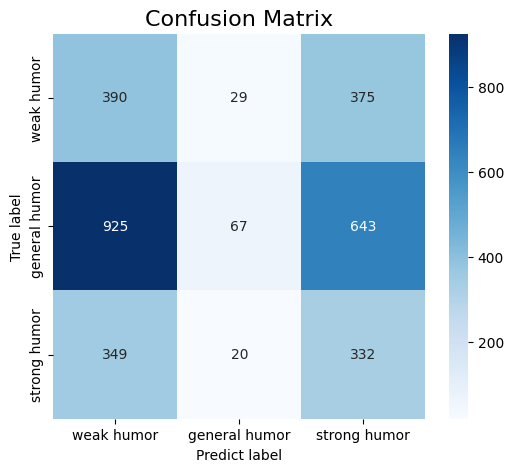

Classification Report
              precision    recall  f1-score   support

           0       0.23      0.49      0.32       794
           1       0.58      0.04      0.08      1635
           2       0.25      0.47      0.32       701

    accuracy                           0.25      3130
   macro avg       0.35      0.34      0.24      3130
weighted avg       0.42      0.25      0.19      3130



In [31]:
evaluate(prediction["label"], prediction["1-shot-random"])

# 保存数据

In [20]:
data = pd.read_csv("./data/prediction.csv")
data["1-shot-knn"] = prediction["1-shot-knn"]
data.to_csv("./data/prediction.csv", index=False)